In [14]:
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_intermediate_values


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



from code.wrapper import utils

import optuna
import itertools
import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
# https://stackoverflow.com/a/23835410

excel_sheet = pd.read_excel("../Data/New/unfiltered_data.xlsx", sheet_name=["full_train", "full_test",
                                                                            "ionizable_train", "ionizable_test",
                                                                            "neutral_train", "neutral_test"])


full_train: pd.DataFrame = excel_sheet["full_train"]
full_test: pd.DataFrame = excel_sheet["full_test"]

neutral_train: pd.DataFrame = excel_sheet["neutral_train"]
neutral_test: pd.DataFrame = excel_sheet["neutral_test"]

ionizable_train: pd.DataFrame = excel_sheet["ionizable_train"]
ionizable_test: pd.DataFrame = excel_sheet["ionizable_test"]

Scaler = RobustScaler()
Norm = Normalizer()
# TRAIN
X_full_train = full_train.loc[:, full_train.columns != "Log_MP_RATIO"]
y_full_train = full_train["Log_MP_RATIO"]


X_neutral_train = neutral_train.loc[:, neutral_train.columns != "Log_MP_RATIO"]
y_neutral_train = neutral_train["Log_MP_RATIO"]

X_ionizable_train = ionizable_train.loc[:, ionizable_train.columns != "Log_MP_RATIO"]
y_ionizable_train = ionizable_train["Log_MP_RATIO"]
# Scaler.fit(X_full_train)
# X_full_train = pd.DataFrame(Scaler.transform(X_full_train), columns = X_full_train.columns)
#
# Norm.fit(X_full_train)
# X_full_train = pd.DataFrame(Norm.transform(X_full_train), columns=X_full_train.columns)

# TEST
X_full_test = full_test.loc[:, full_test.columns != "Log_MP_RATIO"]
y_full_test = full_test["Log_MP_RATIO"]

X_neutral_test = neutral_test.loc[:, neutral_test.columns != "Log_MP_RATIO"]
y_neutral_test = neutral_test["Log_MP_RATIO"]

X_ionizable_test = ionizable_test.loc[:, ionizable_test.columns != "Log_MP_RATIO"]
y_ionizable_test = ionizable_test["Log_MP_RATIO"]
#
# Scaler.fit(X_full_test)
# X_full_test = pd.DataFrame(Scaler.transform(X_full_test), columns = X_full_test.columns)
#
# Norm.fit(X_full_test)
# X_full_test = pd.DataFrame(Norm.transform(X_full_test), columns=X_full_test.columns)

In [37]:
def objective(trial, data):
    alpha = trial.suggest_float('alpha', 1e-10, 1e10, log=True)

    tol = trial.suggest_float("tol", 1e-10, 1e-2, log=False)

    # selection = trial.suggest_categorical("selection", ["cyclic", "random"])

    clf = Lasso(max_iter=1000000, alpha=alpha, random_state=0)

    # n_ft = trial.suggest_int('n_ft', 1, 10, log=True)
    # clf = RFE(Ridge(max_iter=100000, alpha=alpha, solver=solver), n_features_to_select=n_ft)

    estimator = utils.Utils(data)
    return estimator.cross_value_score(clf)

    # return cross_val_score(clf, X_full_train, y_full_train, cv=3, n_jobs=-1).mean()


# Full

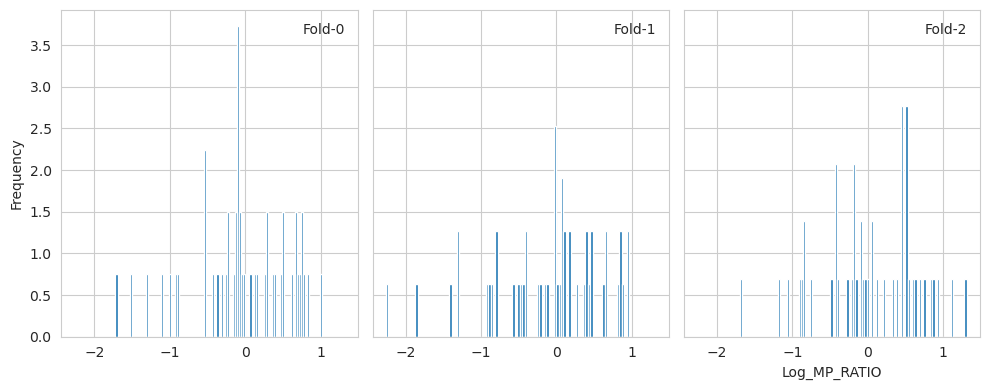

Scores: 
	R2				:	 0.582218708424428 
	CV train		:	 0.33334189225390537 
	Custom CV train	:	 0.3587654533571763 
	Q2				:	 0.04357229422213604


In [27]:
test_utils = utils.Utils(full_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(Lasso(max_iter=1000000), X_full_train, y_full_train, X_full_test, y_full_test)

In [49]:
func = lambda trial: objective(trial, full_train)

study = optuna.create_study(direction='maximize')
study.optimize(func, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

[I 2023-06-15 15:44:41,169] A new study created in memory with name: no-name-96b7e4a0-124d-4846-93bc-1c6d3f5b7ff9


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-06-15 15:44:42,228] Trial 0 finished with value: -1.459311714414366 and parameters: {'alpha': 1.2166618474964044e-98, 'tol': 0.0038073361107639064}. Best is trial 0 with value: -1.459311714414366.
[I 2023-06-15 15:44:42,277] Trial 5 finished with value: -1.459311714414366 and parameters: {'alpha': 4.3913255660507934e-89, 'tol': 0.009717188530062015}. Best is trial 0 with value: -1.459311714414366.
[I 2023-06-15 15:44:42,315] Trial 1 finished with value: -1.459311714414366 and parameters: {'alpha': 1.4451101177670428e-43, 'tol': 0.006575307714540988}. Best is trial 0 with value: -1.459311714414366.
[I 2023-06-15 15:44:42,424] Trial 6 finished with value: -1.459311714414366 and parameters: {'alpha': 2.2021264754155103e-78, 'tol': 0.0003595991246412039}. Best is trial 0 with value: -1.459311714414366.
[I 2023-06-15 15:44:42,497] Trial 2 finished with value: -1.4593069171458566 and parameters: {'alpha': 4.815248702492356e-11, 'tol': 0.009799301653695674}. Best is trial 2 with value


KeyboardInterrupt



Scores: 
	R2				:	 0.5853642921766097 
	CV train		:	 0.32399483006175717 
	Custom CV train	:	 0.3565717620164845 
	Q2				:	 0.07935188595674025


AttributeError: 'str' object has no attribute 'items'

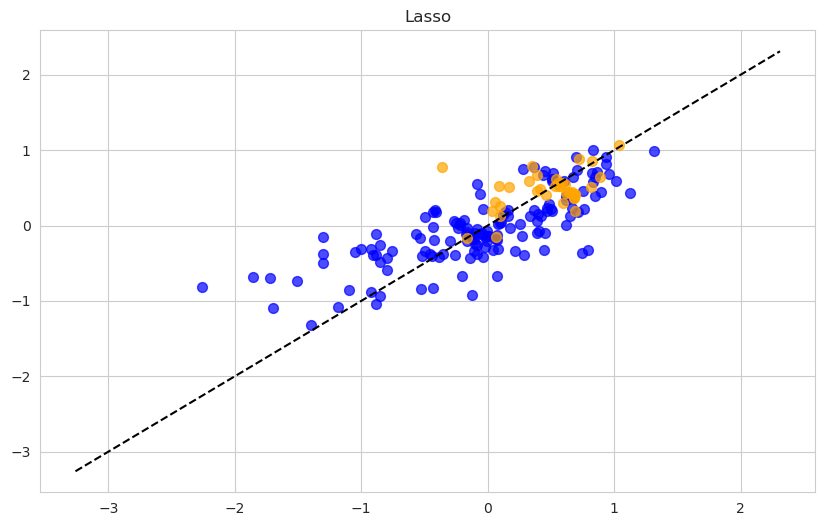

In [21]:
test_utils.display_score(Lasso(**study.best_params), X_full_train, y_full_train, X_full_test, y_full_test)
display(plot_optimization_history(study))

rr = Lasso(**study.best_params).fit(X_full_train, y_full_train)
y_full_train_pred = rr.predict(X_full_train)
y_full_test_pred = rr.predict(X_full_test)

from code.wrapper import utils

test_utils.display_graph(rr, X_full_train, X_full_test, y_full_train, y_full_test)

# Ionizable

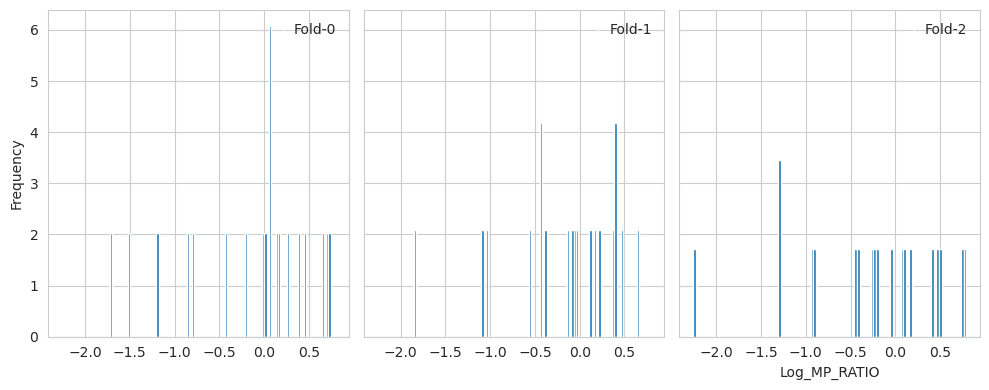

Scores: 
	R2				:	 0.6705568553511401 
	CV train		:	 -0.42592181174545446 
	Custom CV train	:	 -1.0371764683762894 
	Q2				:	 0.26299594771886803


In [6]:
test_utils = utils.Utils(ionizable_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(Lasso(random_state=0), X_ionizable_train, y_ionizable_train, X_ionizable_test, y_ionizable_test)

In [7]:
import optuna


def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1e10, log=True)

    tol = trial.suggest_float("tol", 1e-10, 1e-2, log=True)

    # selection = trial.suggest_categorical("selection", ["cyclic", "random"])

    clf = Lasso(max_iter=100000, alpha=alpha, random_state=0)

    # n_ft = trial.suggest_int('n_ft', 1, 10, log=True)
    # clf = RFE(Ridge(max_iter=100000, alpha=alpha, solver=solver), n_features_to_select=n_ft)

    estimator = utils.Utils(ionizable_train)
    return estimator.cross_value_score(clf)

    # return cross_val_score(clf, X_ionizable_train, y_ionizable_train, cv=3, n_jobs=-1).mean()



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

[I 2023-06-14 13:39:44,273] A new study created in memory with name: no-name-5d7ac5a7-4d16-4378-a209-66f0f5583c88


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-06-14 13:39:45,041] Trial 0 finished with value: -0.009217972097849803 and parameters: {'alpha': 10304.023493227383, 'tol': 1.4978764414941595e-10}. Best is trial 0 with value: -0.009217972097849803.
[I 2023-06-14 13:39:45,045] Trial 3 finished with value: -0.009217972097849803 and parameters: {'alpha': 1658189.0425326051, 'tol': 6.234189116722642e-09}. Best is trial 0 with value: -0.009217972097849803.
[I 2023-06-14 13:39:45,047] Trial 2 finished with value: -0.009217972097849803 and parameters: {'alpha': 90512.69047493099, 'tol': 1.5327948776011176e-10}. Best is trial 0 with value: -0.009217972097849803.
[I 2023-06-14 13:39:45,089] Trial 1 finished with value: -0.009217972097849803 and parameters: {'alpha': 849436.092646567, 'tol': 9.828318044353274e-06}. Best is trial 0 with value: -0.009217972097849803.
[I 2023-06-14 13:39:45,130] Trial 6 finished with value: -0.013935986188580607 and parameters: {'alpha': 264.757302156825, 'tol': 4.029499704707316e-06}. Best is trial 0 wit

In [5]:
# 0.3334568442254273 {'alpha': 1.029899802316505, 'tol': 8.492961565138823e-08}
test_utils = utils.Utils(ionizable_train)
test_utils.display_score(Lasso(**study.best_params, random_state=0), X_ionizable_train, y_ionizable_train, X_ionizable_test, y_ionizable_test)
study.best_params

Scores: 
	R2				:	 0.0 
	CV train		:	 -0.13309422920482886 
	Custom CV train	:	 -0.009217972097849803 
	Q2				:	 -0.07261748682007574


{'alpha': 14573.566055933752, 'tol': 0.002460006941927946}

In [6]:
Lasso(**({'alpha': 14573.566055933752, 'tol': 0.002460006941927946})).fit(X_ionizable_train, y_ionizable_train).score(X_ionizable_train, y_ionizable_train)

0.0

# Neutral

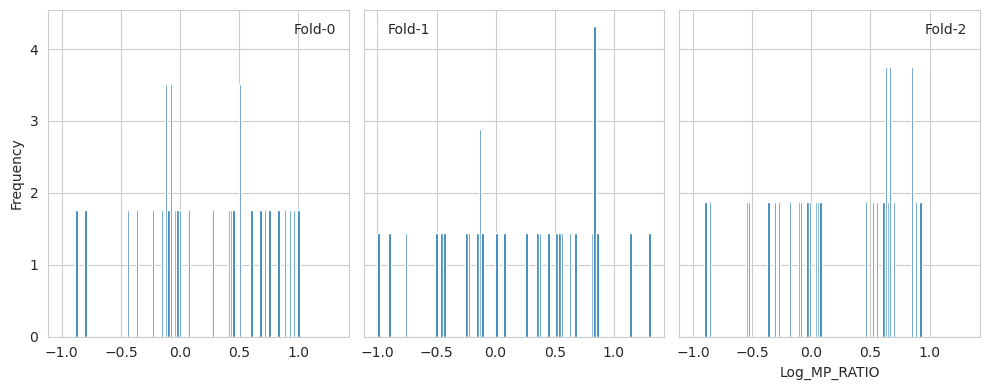

Scores: 
	R2				:	 0.7387229802449276 
	CV train		:	 -2.791023462059474 
	Custom CV train	:	 -0.1872783341605918 
	Q2				:	 0.42665036862299255


In [3]:
test_utils = utils.Utils(neutral_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(Lasso(random_state=0), X_neutral_train, y_neutral_train, X_neutral_test, y_neutral_test)

In [4]:
import optuna


def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1e10, log=True)

    tol = trial.suggest_float("tol", 1e-10, 1e-2, log=True)

    # selection = trial.suggest_categorical("selection", ["cyclic", "random"])

    clf = Lasso(max_iter=100000, alpha=alpha, random_state=0)

    # n_ft = trial.suggest_int('n_ft', 1, 10, log=True)
    # clf = RFE(Ridge(max_iter=100000, alpha=alpha, solver=solver), n_features_to_select=n_ft)

    estimator = utils.Utils(neutral_train)
    return estimator.cross_value_score(clf)

    # return cross_val_score(clf, X_neutral_train, y_neutral_train, cv=3, n_jobs=-1).mean()



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

[I 2023-06-14 14:48:22,202] A new study created in memory with name: no-name-f06db4b3-7959-43c5-b3ca-871361e3c1a2


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-06-14 14:48:22,790] Trial 6 finished with value: -0.0010605577384500038 and parameters: {'alpha': 677153456.728915, 'tol': 0.0016388951288256067}. Best is trial 6 with value: -0.0010605577384500038.
[I 2023-06-14 14:48:22,791] Trial 2 finished with value: -0.0010605577384500038 and parameters: {'alpha': 2586118.5454905434, 'tol': 0.0047222712706040115}. Best is trial 6 with value: -0.0010605577384500038.
[I 2023-06-14 14:48:22,869] Trial 1 finished with value: -0.0010605577384500038 and parameters: {'alpha': 146361.83922683977, 'tol': 1.0709451339907242e-06}. Best is trial 6 with value: -0.0010605577384500038.
[I 2023-06-14 14:48:22,872] Trial 4 finished with value: -0.0010605577384500038 and parameters: {'alpha': 1649519653.7794986, 'tol': 0.005959385028949713}. Best is trial 6 with value: -0.0010605577384500038.
[I 2023-06-14 14:48:22,932] Trial 7 finished with value: -0.0010605577384500038 and parameters: {'alpha': 3281076327.478025, 'tol': 1.2624916719471834e-05}. Best is t

In [5]:
# 0.3334568442254273 {'alpha': 1.029899802316505, 'tol': 8.492961565138823e-08}
test_utils = utils.Utils(neutral_train)
test_utils.display_score(Lasso(**study.best_params, max_iter=100000, random_state=0), X_neutral_train, y_neutral_train, X_neutral_test, y_neutral_test)
study.best_params

Scores: 
	R2				:	 0.8646454554373421 
	CV train		:	 -6.221710294023929 
	Custom CV train	:	 0.4203955631205584 
	Q2				:	 0.1486495919856773


{'alpha': 0.19804751366722934, 'tol': 8.932970378830144e-08}

In [33]:
display(plot_optimization_history(study))
plot_intermediate_values(study)



[W 2023-06-14 16:29:54,448] You need to set up the pruning feature to utilize `plot_intermediate_values()`


[W 2023-06-14 16:28:25,650] You need to set up the pruning feature to utilize `plot_intermediate_values()`


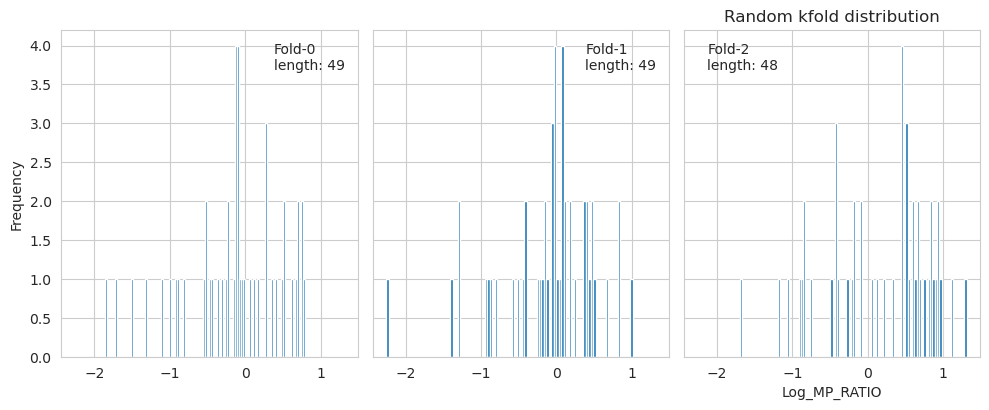

In [24]:
from sklearn.model_selection import KFold

folds = KFold(3)



from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,4))
for i, (train_index, test_index) in enumerate(folds.split(X=X_full_train, y=y_full_train)):
    axs[i].hist(y_full_train.iloc[test_index], bins=100, label=f"Fold-{i}\nlength: {len(test_index)}")
    axs[i].legend(frameon=False, handlelength=0)
    if i == 0:
        axs[i].set_ylabel("Frequency")
    if i == 2:
        axs[i].set_xlabel("Log_MP_RATIO")
plt.tight_layout()
plt.title("Random kfold distribution")
plt.show()